# Language Classification Simulation (English / Spanish / French)
- Purpose: quick baseline and model comparison on MFCC and spectrogram images.
- Datasets: folder-per-class with images inside.
- Output: accuracy per model and confusion matrices.


In [1]:
# CUDA diagnostics and kernel path check
import sys, platform, torch
print(f"Python: {sys.version.split()[0]} on {platform.system()} {platform.release()}")
print(f"Interpreter: {sys.executable}")
print(f"PyTorch: {getattr(torch, '__version__', 'n/a')}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"torch.version.cuda: {torch.version.cuda}")
print(f"cuDNN available: {torch.backends.cudnn.is_available()}")
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        name = torch.cuda.get_device_name(i)
        print(f"  [{i}] {name} | CC {props.major}.{props.minor} | {(props.total_memory/1e9):.1f} GB")
else:
    print("CUDA is currently unavailable in this kernel.")


Python: 3.12.7 on Windows 11
Interpreter: c:\Users\Lukita\anaconda3\python.exe
PyTorch: 2.9.1+cu126
CUDA available: True
torch.version.cuda: 12.6
cuDNN available: True
GPU count: 1
  [0] NVIDIA GeForce RTX 4070 Laptop GPU | CC 8.9 | 8.6 GB


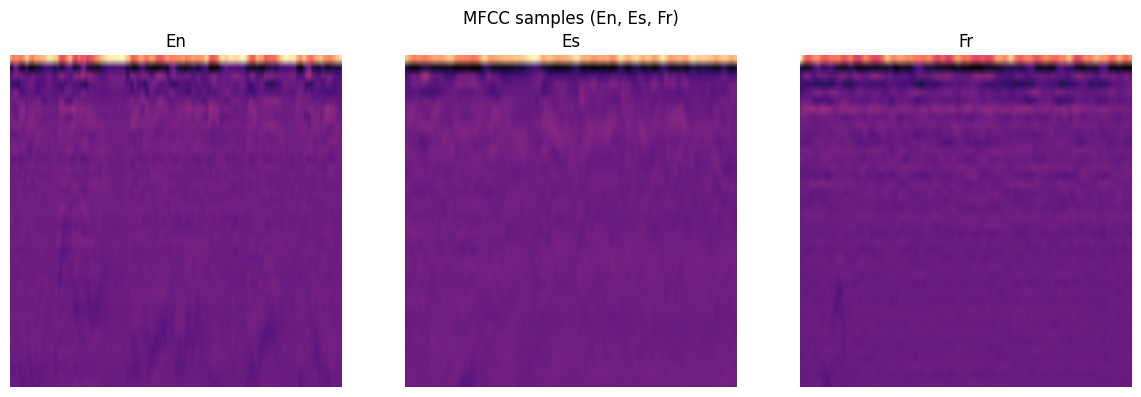

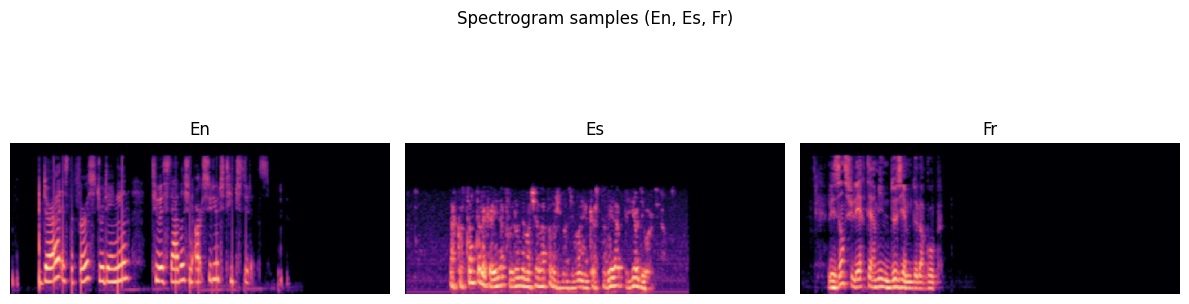

In [ ]:
# Quick visual sanity check: show MFCC and spectrogram examples
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

mfcc_samples = [
    Path("MFCC_images/En/common_voice_en_40205636_mfcc.png"),
    Path("MFCC_images/Es/common_voice_es_40198330_mfcc.png"),
    Path("MFCC_images/Fr/common_voice_fr_40211225_mfcc.png"),
]

spectro_samples = [
    Path("spectrogram_images/En/common_voice_en_40323223.jpg"),
    Path("spectrogram_images/Es/common_voice_es_40198121.jpg"),
    Path("spectrogram_images/Fr/common_voice_fr_40211219.jpg"),
]

def show_images(paths, title):
    cols = len(paths)
    plt.figure(figsize=(4 * cols, 4))
    for i, p in enumerate(paths, 1):
        img = Image.open(p).convert("RGB")
        ax = plt.subplot(1, cols, i)
        ax.imshow(img)
        ax.set_title(p.parent.name)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(mfcc_samples, "MFCC samples (En, Es, Fr)")
show_images(spectro_samples, "Spectrogram samples (En, Es, Fr)")

In [3]:
# Dataset builders for MFCC and Spectrogram (using torchvision ImageFolder)
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import torch
from torchvision import transforms, datasets

IMG_SIZE = 128
BATCH_SIZE = 16
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

basic_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def build_loaders(root_dir: str):
    ds = datasets.ImageFolder(root=root_dir, transform=basic_transform)
    full_len = len(ds)
    val_len = int(full_len * VAL_SPLIT)
    test_len = int(full_len * TEST_SPLIT)
    train_len = full_len - val_len - test_len
    train_ds, val_ds, test_ds = random_split(ds, [train_len, val_len, test_len])
    # Use pin_memory when running on CUDA for faster host->device copies
    pm = globals().get('pin_memory', False)
    return {
        "train": DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=pm),
        "val": DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "test": DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "classes": ds.classes,
    }

mfcc_root = str(Path("MFCC_images"))
spectro_root = str(Path("spectrogram_images"))

mfcc_data = build_loaders(mfcc_root)
spectro_data = build_loaders(spectro_root)

print("MFCC classes:", mfcc_data["classes"])
print("Spectrogram classes:", spectro_data["classes"])

MFCC classes: ['En', 'Es', 'Fr']
Spectrogram classes: ['En', 'Es', 'Fr']


In [ ]:
# Model builders: SmallCNN, VGG16, AlexNet, ResNet18, CNNLSTM
import math
from torch import nn

class SmallCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
)
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

def make_vgg16(num_classes=3):
    from torchvision import models
    m = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    return m

def make_alexnet(num_classes=3):
    from torchvision import models
    m = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    return m

def make_resnet18(num_classes=3):
    from torchvision import models
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=3, slices=8):
        super().__init__()
        self.slices = slices
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
)
        self.cnn_out = 64 * (IMG_SIZE//4) * (IMG_SIZE//(4*self.slices))
        self.proj = nn.Linear(self.cnn_out, 256)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.head = nn.Linear(128, num_classes)
    def forward(self, x):
        B, C, H, W = x.shape
        slice_h = H // self.slices
        seq_feats = []
        for i in range(self.slices):
            band = x[:, :, i*slice_h:(i+1)*slice_h, :]
            f = self.cnn(band)
            f = f.reshape(B, -1)
            f = self.proj(f)
            seq_feats.append(f)
        seq = torch.stack(seq_feats, dim=1)
        out, _ = self.lstm(seq)
        last = out[:, -1, :]
        return self.head(last)

In [ ]:
# Training and evaluation utilities

import time
import numpy as np
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn
import torch.nn.functional as F

# Ensure loaders exist
from pathlib import Path
IMG_SIZE = globals().get('IMG_SIZE', 128)
BATCH_SIZE = globals().get('BATCH_SIZE', 16)
VAL_SPLIT = globals().get('VAL_SPLIT', 0.15)
TEST_SPLIT = globals().get('TEST_SPLIT', 0.15)
from torchvision import transforms, datasets
basic_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def build_loaders(root_dir: str):
    ds = datasets.ImageFolder(root=root_dir, transform=basic_transform)
    full_len = len(ds)
    val_len = int(full_len * VAL_SPLIT)
    test_len = int(full_len * TEST_SPLIT)
    train_len = full_len - val_len - test_len
    from torch.utils.data import random_split
    train_ds, val_ds, test_ds = random_split(ds, [train_len, val_len, test_len])
    pm = globals().get('pin_memory', False)
    return {
        "train": DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=pm),
        "val": DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "test": DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "classes": ds.classes,
    }

mfcc_root = str(Path("MFCC_images"))
spectro_root = str(Path("spectrogram_images"))
mfcc_data = build_loaders(mfcc_root)
spectro_data = build_loaders(spectro_root)

from torch.cuda.amp import autocast, GradScaler

def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None, use_amp=False):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    nb = globals().get('non_blocking', False)
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=nb)
        yb = torch.as_tensor(yb, device=device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)
        if scaler is not None and use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += float(loss) * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += int((preds == yb).sum())
        total += xb.size(0)
    return total_loss / max(total, 1), correct / max(total, 1)

def evaluate(model, loader, criterion, device, use_amp=False):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []
    nb = globals().get('non_blocking', False)
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=nb)
            yb = torch.as_tensor(yb, device=device)
            with autocast(enabled=use_amp):
                logits = model(xb)
                loss = criterion(logits, yb)
            total_loss += float(loss) * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += int((preds == yb).sum())
            total += xb.size(0)
            all_preds.append(preds.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    y_pred = np.concatenate(all_preds) if all_preds else np.array([])
    y_true = np.concatenate(all_targets) if all_targets else np.array([])
    return avg_loss, acc, y_true, y_pred

def run_training(model_builder, data: Dict[str, DataLoader], name: str, epochs=6, lr=1e-3, patience=3):
    dev = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model = model_builder().to(dev)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    use_amp_local = dev.type == 'cuda'
    scaler = GradScaler(enabled=use_amp_local)
    if dev.type == 'cuda':
        torch.backends.cudnn.benchmark = True
    best_val_loss = float('inf')
    best_state = None
    wait = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, data["train"], criterion, optimizer, dev, scaler=scaler, use_amp=use_amp_local)
        val_loss, val_acc, _, _ = evaluate(model, data["val"], criterion, dev, use_amp=use_amp_local)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"[{name}] Epoch {ep:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"[{name}] Early stopping at epoch {ep}")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(dev)
    test_loss, test_acc, y_true, y_pred = evaluate(model, data["test"], criterion, dev, use_amp=use_amp_local)
    print(f"[{name}] Test loss={test_loss:.4f} acc={test_acc:.3f}")
    return model, history, (test_loss, test_acc, y_true, y_pred)

## Model comparison overview

models_to_run = []
models_to_run.append(("SmallCNN", lambda: SmallCNN(num_classes=3)))
models_to_run.append(("CNNLSTM", lambda: CNNLSTM(num_classes=3, slices=8)))
models_to_run.extend([
    ("ResNet18", lambda: make_resnet18(num_classes=3)),
    ("AlexNet", lambda: make_alexnet(num_classes=3)),
    ("VGG16", lambda: make_vgg16(num_classes=3)),
])

results = []
best_overall_acc = -1.0
best_model = None
best_y_true = None
best_y_pred = None
data = mfcc_data  # change to spectro_data to compare on spectrograms
classes = data["classes"]
for name, builder in models_to_run:
    print(f"\n=== Training {name} on MFCC images ===")
    model, history, (tl, ta, y_true, y_pred) = run_training(builder, data, name=name, epochs=6, lr=1e-3, patience=3)
    results.append({"name": name, "test_loss": tl, "test_acc": ta})
    if ta > best_overall_acc and y_true.size and y_pred.size:
        best_overall_acc = ta
        best_model = model
        best_y_true = y_true
        best_y_pred = y_pred
    if y_true.size and y_pred.size:
        cm = confusion_matrix(y_true, y_pred)
        print(f"Confusion Matrix ({name}):\n{cm}")
        report = classification_report(y_true, y_pred, target_names=classes)
        print(report)

print("\nSummary:")
for r in sorted(results, key=lambda x: x["test_acc"], reverse=True):
    print(f"{r['name']}: acc={r['test_acc']:.3f} loss={r['test_loss']:.4f}")
if best_model is not None:
    print(f"Best cached model: acc={best_overall_acc:.3f}")
else:
    print("Best cached model unavailable (no predictions cached).")


=== Training SmallCNN on MFCC images ===


C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp_local)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:66: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  total_loss += float(loss) * xb.size(0)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use 

[SmallCNN] Epoch 01 | train_loss=0.8485 acc=0.600 | val_loss=0.7742 acc=0.650
[SmallCNN] Epoch 02 | train_loss=0.7004 acc=0.690 | val_loss=0.7653 acc=0.666
[SmallCNN] Epoch 03 | train_loss=0.6246 acc=0.728 | val_loss=0.6243 acc=0.722
[SmallCNN] Epoch 04 | train_loss=0.5589 acc=0.762 | val_loss=0.5702 acc=0.756
[SmallCNN] Epoch 05 | train_loss=0.4974 acc=0.791 | val_loss=0.5361 acc=0.770
[SmallCNN] Epoch 06 | train_loss=0.4358 acc=0.821 | val_loss=0.5509 acc=0.774
[SmallCNN] Test loss=0.5374 acc=0.780
Confusion Matrix (SmallCNN):
[[773  88  72]
 [154 834  65]
 [123  45 337]]
              precision    recall  f1-score   support

          En       0.74      0.83      0.78       933
          Es       0.86      0.79      0.83      1053
          Fr       0.71      0.67      0.69       505

    accuracy                           0.78      2491
   macro avg       0.77      0.76      0.76      2491
weighted avg       0.78      0.78      0.78      2491


=== Training CNNLSTM on MFCC images =

C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp_local)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


[CNNLSTM] Epoch 01 | train_loss=0.9702 acc=0.527 | val_loss=0.9248 acc=0.575
[CNNLSTM] Epoch 02 | train_loss=0.8568 acc=0.603 | val_loss=0.8435 acc=0.607
[CNNLSTM] Epoch 03 | train_loss=0.8141 acc=0.626 | val_loss=0.8295 acc=0.624
[CNNLSTM] Epoch 04 | train_loss=0.7732 acc=0.647 | val_loss=0.8039 acc=0.617
[CNNLSTM] Epoch 05 | train_loss=0.7524 acc=0.661 | val_loss=0.7667 acc=0.652
[CNNLSTM] Epoch 06 | train_loss=0.7326 acc=0.670 | val_loss=0.7612 acc=0.652
[CNNLSTM] Test loss=0.7573 acc=0.657
Confusion Matrix (CNNLSTM):
[[624 173 136]
 [177 824  52]
 [205 112 188]]
              precision    recall  f1-score   support

          En       0.62      0.67      0.64       933
          Es       0.74      0.78      0.76      1053
          Fr       0.50      0.37      0.43       505

    accuracy                           0.66      2491
   macro avg       0.62      0.61      0.61      2491
weighted avg       0.65      0.66      0.65      2491


=== Training ResNet18 on MFCC images ===


C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp_local)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


[ResNet18] Epoch 01 | train_loss=0.7330 acc=0.687 | val_loss=0.6825 acc=0.736
[ResNet18] Epoch 02 | train_loss=0.5058 acc=0.797 | val_loss=0.8546 acc=0.668
[ResNet18] Epoch 03 | train_loss=0.4023 acc=0.844 | val_loss=0.4673 acc=0.822
[ResNet18] Epoch 04 | train_loss=0.3247 acc=0.879 | val_loss=0.4210 acc=0.837
[ResNet18] Epoch 05 | train_loss=0.2555 acc=0.907 | val_loss=0.3438 acc=0.860
[ResNet18] Epoch 06 | train_loss=0.1863 acc=0.933 | val_loss=0.3861 acc=0.866
[ResNet18] Test loss=0.3564 acc=0.859
Confusion Matrix (ResNet18):
[[797  96  40]
 [ 59 974  20]
 [ 88  47 370]]
              precision    recall  f1-score   support

          En       0.84      0.85      0.85       933
          Es       0.87      0.92      0.90      1053
          Fr       0.86      0.73      0.79       505

    accuracy                           0.86      2491
   macro avg       0.86      0.84      0.85      2491
weighted avg       0.86      0.86      0.86      2491


=== Training AlexNet on MFCC images =

C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp_local)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
C:\Users\Lukita\AppData\Local\Temp\ipykernel_19404\3663118615.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


[AlexNet] Epoch 01 | train_loss=1.0694 acc=0.432 | val_loss=1.0601 acc=0.438
[AlexNet] Epoch 02 | train_loss=1.0594 acc=0.431 | val_loss=1.0588 acc=0.438
[AlexNet] Epoch 03 | train_loss=1.0585 acc=0.434 | val_loss=1.0578 acc=0.438
[AlexNet] Epoch 04 | train_loss=1.0575 acc=0.436 | val_loss=1.0566 acc=0.438
[AlexNet] Epoch 05 | train_loss=1.0576 acc=0.435 | val_loss=1.0573 acc=0.438
[AlexNet] Epoch 06 | train_loss=1.0574 acc=0.435 | val_loss=1.0582 acc=0.438
[AlexNet] Test loss=1.0579 acc=0.423
Confusion Matrix (AlexNet):
[[   0  933    0]
 [   0 1053    0]
 [   0  505    0]]
              precision    recall  f1-score   support

          En       0.00      0.00      0.00       933
          Es       0.42      1.00      0.59      1053
          Fr       0.00      0.00      0.00       505

    accuracy                           0.42      2491
   macro avg       0.14      0.33      0.20      2491
weighted avg       0.18      0.42      0.25      2491


=== Training VGG16 on MFCC images ==

c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lukita\AppData\L

[VGG16] Epoch 01 | train_loss=1.1042 acc=0.421 | val_loss=1.0599 acc=0.438
[VGG16] Epoch 02 | train_loss=1.0615 acc=0.424 | val_loss=1.0567 acc=0.438
[VGG16] Epoch 03 | train_loss=1.0611 acc=0.427 | val_loss=1.0604 acc=0.438
[VGG16] Epoch 04 | train_loss=1.0587 acc=0.432 | val_loss=1.0599 acc=0.438
[VGG16] Epoch 05 | train_loss=1.0587 acc=0.431 | val_loss=1.0586 acc=0.438
[VGG16] Early stopping at epoch 5
[VGG16] Test loss=1.0572 acc=0.423
Confusion Matrix (VGG16):
[[   0  933    0]
 [   0 1053    0]
 [   0  505    0]]
              precision    recall  f1-score   support

          En       0.00      0.00      0.00       933
          Es       0.42      1.00      0.59      1053
          Fr       0.00      0.00      0.00       505

    accuracy                           0.42      2491
   macro avg       0.14      0.33      0.20      2491
weighted avg       0.18      0.42      0.25      2491


Summary:
ResNet18: acc=0.859 loss=0.3564
SmallCNN: acc=0.780 loss=0.5374
CNNLSTM: acc=0.657 l

c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


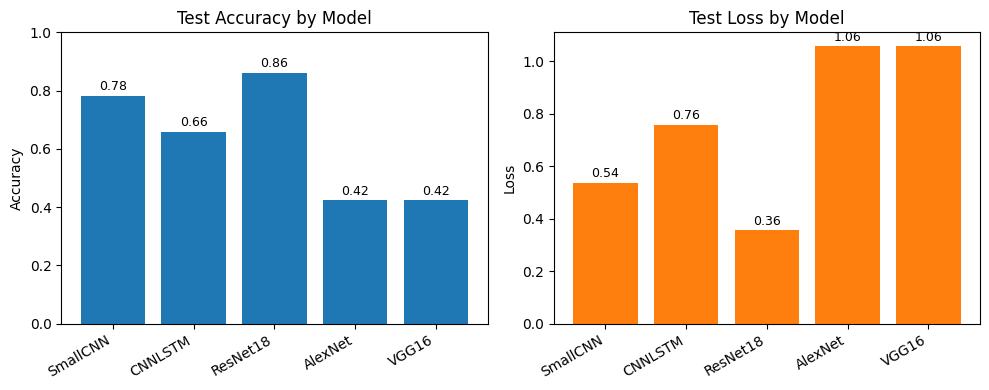

Best model: ResNet18


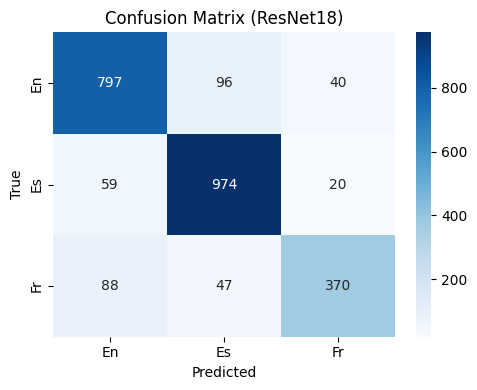

In [6]:
# Visualization: plot model evaluation summary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Expect `results`, `classes`, and cached predictions from previous cell
assert isinstance(results, list) and len(results) > 0, "No results found. Please run the training/comparison cell first."

names = [r['name'] for r in results]
accs = [r['test_acc'] for r in results]
losses = [r['test_loss'] for r in results]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
bars = plt.bar(names, accs, color='tab:blue')
plt.title('Test Accuracy by Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
for b, a in zip(bars, accs):
    plt.text(b.get_x() + b.get_width()/2, a + 0.01, f"{a:.2f}", ha='center', va='bottom', fontsize=9)

plt.subplot(1,2,2)
bars2 = plt.bar(names, losses, color='tab:orange')
plt.title('Test Loss by Model')
plt.ylabel('Loss')
plt.xticks(rotation=30, ha='right')
for b, l in zip(bars2, losses):
    plt.text(b.get_x() + b.get_width()/2, l + 0.01, f"{l:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Optional: confusion matrix of the best model if stored
best_idx = int(np.argmax(accs))
best_name = names[best_idx]
print(f"Best model: {best_name}")

# Initialize prediction arrays from globals; plot only when available
best_y_true = globals().get('best_y_true', None)
best_y_pred = globals().get('best_y_pred', None)

if best_y_true is not None and best_y_pred is not None:
    cm = confusion_matrix(best_y_true, best_y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix ({best_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix skipped: best_y_true/best_y_pred not available. Run the training cell to cache predictions.")